In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = 10, 6 # It’s a dictionary of most matplotlib styling that you set at the start of your notebook and it will apply to all your plots.It’s a dictionary of most matplotlib styling that you set at the start of your notebook and it will apply to all your plots.


import pandas as pd
import numpy as np
import scipy as sc
from scipy import signal

import matplotlib.pyplot as plt
import h5py
import obspy
from obspy.signal.filter import envelope
from obspy.clients.fdsn import Client
from tqdm import tqdm #tqdm is a Python library that allows you to output a smart progress bar 
from glob import glob #is a function that’s used to search for files that match a specific file pattern or name.
import tsfel #Time Series Feature Extraction Library is a Python package for feature extraction on time series data.
import random

from scipy import signal


client = Client('IRIS')

import os
import pickle #Pickling” is the process whereby a Python object hierarchy is converted into a byte stream

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork
import matplotlib.dates as mdates

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans #The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset

#%config InlineBackend.figure_format = "png"

#from Feature_Extraction import compute_hibert

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
def extract_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
        st.append(f['/data/'+bucket][ind, :3, :18000])
        
    return st


def convert_into_traces(stream, cat):
    channels = ['BHE','BHN','BHZ']
    
    st = []
    for i in range(len(stream)):
        for j in range(len(stream[i])):
            tr = obspy.Trace(stream[i][j])
            tr.stats.channel = channels[j]
            tr.stats.station = cat['station_code'].values[i]
            tr.stats.network = cat['station_network_code'].values[i]
            tr.stats.sampling_rate = 100
            tr.stats.starttime = obspy.UTCDateTime(cat['trace_start_time'].values[i])
            
            st.append(tr)
            
    return obspy.Stream(st)

def plot_waveforms(tr_exotic_Z, title = 'Thunder Waveforms', xlim = [10,100]):



    # Create a figure with subplots
    fig, axs = plt.subplots(len(tr_exotic_Z), 2, figsize=(12, 12))

    # Plot time series and spectrograms
    for i in range(len(tr_exotic_Z)):
        time = tr_exotic_Z[i].times()
        # Plot time series in left subplot
        axs[i, 0].plot(time, tr_exotic_Z[i].data)
        axs[i, 0].set_xlabel('Time')
        axs[i, 0].set_ylabel('Amplitude')
        axs[i, 0].set_title(tr_exotic_Z[i].id)
        axs[i,0].set_xlim(xlim[0], xlim[1])

        # Compute and plot spectrogram in right subplot
        f, t_spec, Sxx = signal.spectrogram(tr_exotic_Z[i].data, fs = 100)
        axs[i, 1].imshow(Sxx, aspect='auto', cmap='jet', origin='lower', extent=[t_spec.min(), t_spec.max(), f.min(), f.max()])
        axs[i, 1].set_xlabel('Time')
        axs[i, 1].set_ylabel('Frequency')
        axs[i, 1].set_title(str(tr_exotic_Z[i].stats.starttime))
        axs[i, 1].set_xlim(xlim[0], xlim[1])
        axs[i, 1].set_ylim(0, 30)
        #axs[i, 1].set_yscale('log')

    # Labelling the figure. 
    fig.suptitle(title, fontsize = 20)


    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [3]:
# collecting waveform data and corresponding catalog.
exotic_file_name = "/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5"
exotic_csv_file = "/data/whd01/yiyu_data/PNWML/exotic_metadata.csv"

noise_file_name = "/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5"
noise_csv_file = "/data/whd01/yiyu_data/PNWML/noise_metadata.csv"

comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = "/data/whd01/yiyu_data/PNWML/comcat_metadata.csv"

In [4]:
## collecting the catalog and storing it. 
cat_exotic = pd.read_csv(exotic_csv_file)
cat_noise = pd.read_csv(noise_csv_file)
cat_comcat = pd.read_csv(comcat_csv_file)

In [5]:
## making SNR in correct format
snrs_exotic = []
for i in range(len(cat_exotic['trace_snr_db'])):
    snrs_exotic.append(np.array(cat_exotic['trace_snr_db'].values[i].split('|')).astype('float')[-1])
    
snrs_comcat = []
for i in range(len(cat_comcat['trace_snr_db'])):
    snrs_comcat.append(np.array(cat_comcat['trace_snr_db'].values[i].split('|')).astype('float')[-1])

In [6]:
cat_exotic['snr_final'] = snrs_exotic
cat_comcat['snr_final'] = snrs_comcat

In [7]:
cat_thunder = cat_exotic[cat_exotic['source_type'] == 'thunder']
cat_surface = cat_exotic[cat_exotic['source_type'] == 'surface event']
cat_sonic = cat_exotic[cat_exotic['source_type'] == 'sonic boom']
cat_plane = cat_exotic[cat_exotic['source_type'] == 'plane crash']

cat_explosion = cat_comcat[cat_comcat['source_type'] == 'explosion']
cat_earthquake = cat_comcat[cat_comcat['source_type'] == 'earthquake']

In [8]:
cat_thunder_good = cat_thunder.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_surface_good = cat_surface.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_sonic_good = cat_sonic.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_plane_good = cat_plane.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_explosion_good = cat_explosion.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_earthquake_good = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:5]

In [9]:
stream_exotic = extract_waveforms(cat_thunder_good, exotic_file_name)
tr_thunder_Z = convert_into_traces(stream_exotic, cat_thunder_good).select(channel = '*HZ')

stream_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
tr_earthquake_Z = convert_into_traces(stream_earthquake, cat_earthquake_good).select(channel = '*HZ')


stream_surface = extract_waveforms(cat_surface_good, exotic_file_name)
tr_surface_Z = convert_into_traces(stream_surface, cat_surface_good).select(channel = '*HZ')


stream_explosion = extract_waveforms(cat_explosion_good, comcat_file_name)
tr_explosion_Z = convert_into_traces(stream_explosion, cat_explosion_good).select(channel = '*HZ')

stream_sonic = extract_waveforms(cat_sonic_good, exotic_file_name)
tr_sonic_Z = convert_into_traces(stream_sonic, cat_sonic_good).select(channel = '*HZ')

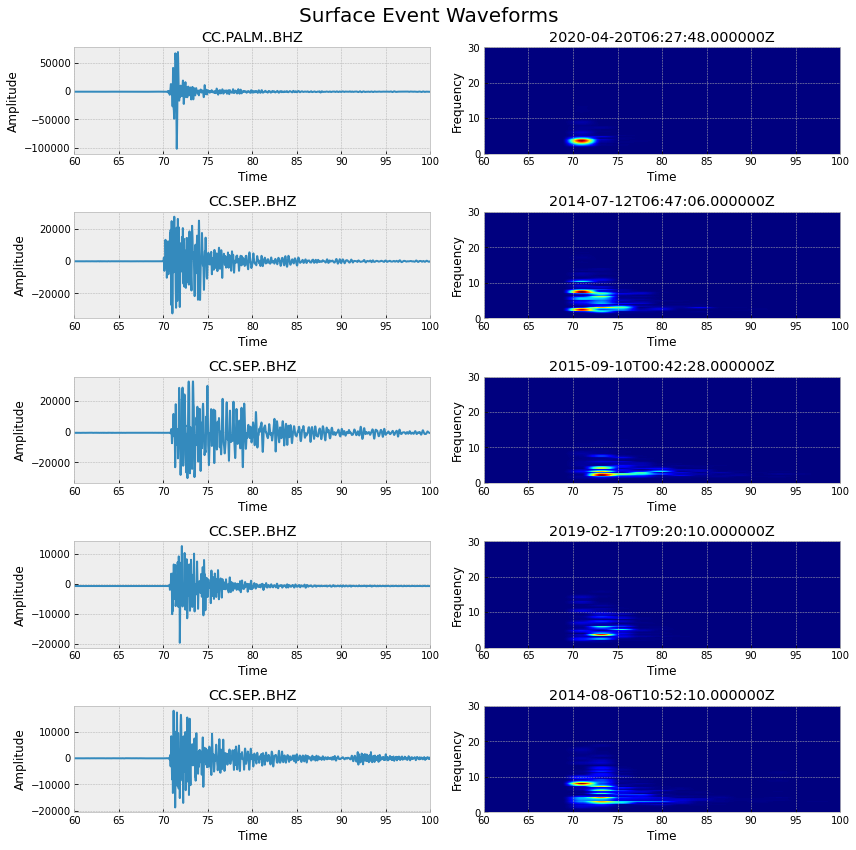

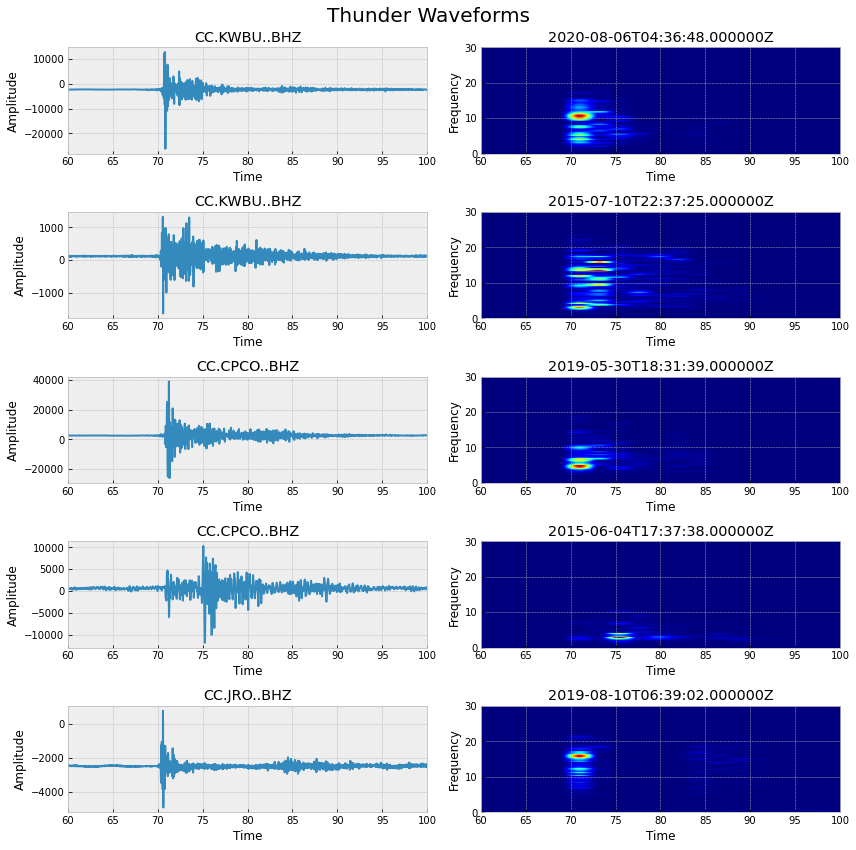

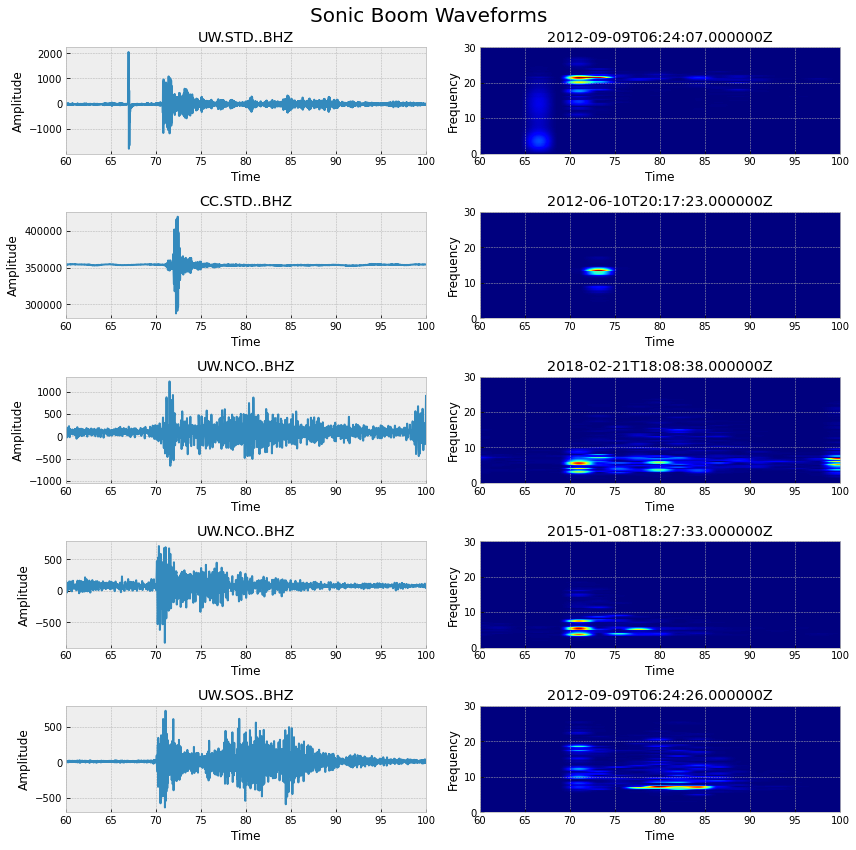

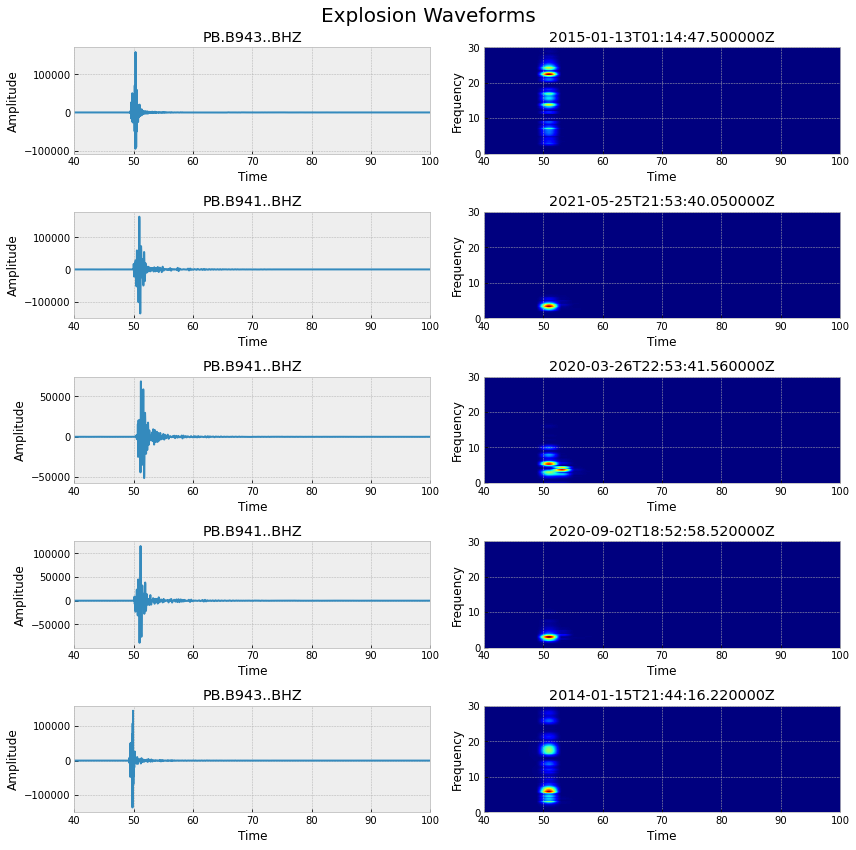

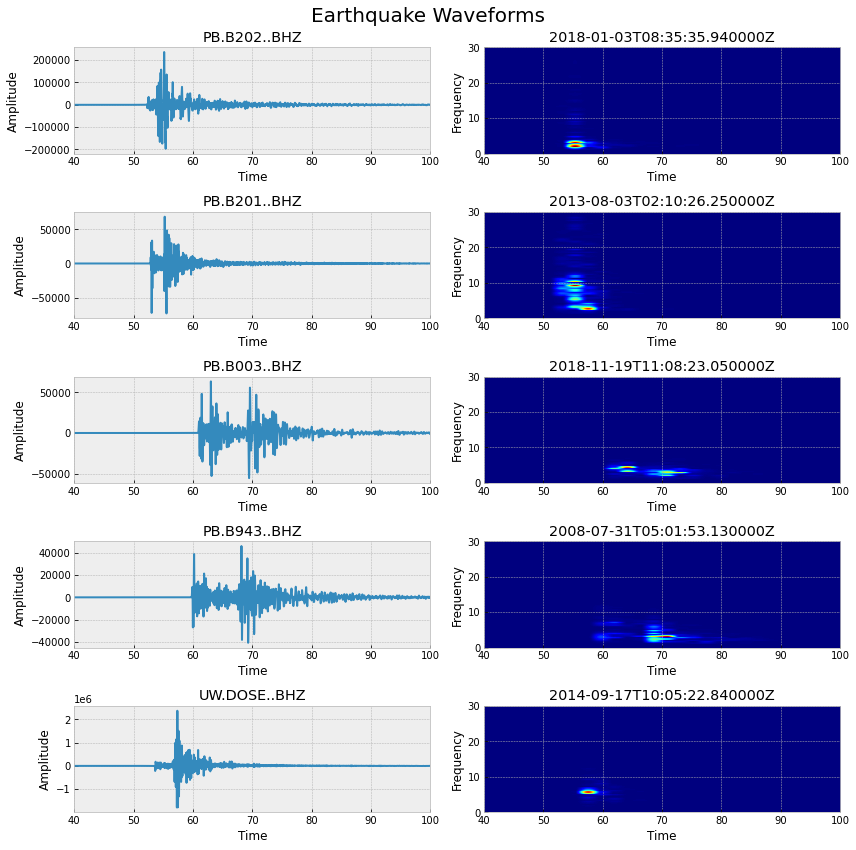

In [10]:
plot_waveforms(tr_surface_Z, title = 'Surface Event Waveforms', xlim = [60,100])
plot_waveforms(tr_thunder_Z, title = 'Thunder Waveforms', xlim = [60,100])
plot_waveforms(tr_sonic_Z, title = 'Sonic Boom Waveforms', xlim = [60,100])
plot_waveforms(tr_explosion_Z, title = 'Explosion Waveforms', xlim = [40,100])
plot_waveforms(tr_earthquake_Z, title = 'Earthquake Waveforms', xlim = [40,100])